In [2]:
!pip install quantecon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.9/206.9 KB 11.6 MB/s eta 0:00:00


In [5]:

import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import cm
import quantecon as qe  
from scipy import optimize
import quantecon as qe
from numpy.linalg import solve


#%% Exercise 1: Testing algorithms with the Rosenbrock function

# Let's use again the Rosenbrock function to test the different algorithms. For each algoritm 
#For each algoritm report: the value x* that minimizes the function, how much time it took to compute it and whether the 
# optimization was succesful

# If the computation takes too much time (let's say 5 minutes) stop the computation and report that the algorithm took too much time.
# Also if you notice your laptop is getting too hot, you might also want to stop the computation. To stop the computation use the stop botton in the console or just close the console.

# a. define the Rosenbrock function for a general N-dimension. (You need to create the function, if you directly import it from somewhere else you will get a 0 for the whole exercise)
def rosen_Nd(X):
    '''Rosenbrock function for N
    f(x) = SUM_i[ (1-xi)+ (x(i+i)-xi)**2
    '''
    y = []
    for i in range(0,len(X)-1):
        yi = (1-X[i])**2+(X[i+1]-X[i]**2)**2
        y.append(yi)
     
    return sum(y)

L(x, λ) = (a - x1)^2 + b(x2 - x1^2)^2 + λ(r - Σ(xi^2))

where x = [x1, x2, ..., xn] is the vector of input variables, λ is the Lagrange multiplier, and Σ(xi^2) is the summation of the squares of the xi values from 1 to n.

In [ ]:
def rosenbrock_lagrangian(x, lamb, a=1, b=100, r=1):
    # Calculate the value of the Rosenbrock function
    f = (a - x[0])**2 + b*(x[1] - x[0]**2)**2
    
    # Calculate the value of the constraint term
    g = r - sum([xi**2 for xi in x])
    
    # Calculate the Lagrangian
    L = f + lamb*g
    
    return L

In [ ]:
def rosenbrock_lagrangian_gradient(x, lamb, a=1, b=100, r=1):
    # Calculate the gradient of the Rosenbrock function
    dfdx1 = 2*(x[0] - a) - 4*b*x[0]*(x[1] - x[0]**2)
    dfdx2 = 2*b*(x[1] - x[0]**2)
    
    # Calculate the gradient of the constraint term
    dgdx = [-2*xi*lamb for xi in x]
    
    # Combine the gradients to get the overall gradient of the Lagrangian
    DLdx = [dfdx1 + dgdx[0], dfdx2 + dgdx[1]]
    
    return DLdx

In [ ]:

def rosenbrock_lagrangian_hessian(x, lamb, a=1, b=100, r=1):
    # Calculate the Hessian of the Rosenbrock function
    d2fdx1x1 = 2 - 4*b*x[1] + 12*b*x[0]**2
    d2fdx1x2 = -4*b*x[0]
    d2fdx2x1 = -4*b*x[0]
    d2fdx2x2 = 2*b
    
    Hf = np.array([[d2fdx1x1, d2fdx1x2], [d2fdx2x1, d2fdx2x2]])
    
    # Calculate the Hessian of the constraint term
    d2gdxixj = -2*lamb*np.identity(len(x))
    
    Hg = d2gdxixj
    
    # Combine the Hessians to get the overall Hessian of the Lagrangian
    DLdx = np.array([2*(x[0] - a) - 4*b*x[0]*(x[1] - x[0]**2), 2*b*(x[1] - x[0]**2)])
    
    H = Hf + lamb*Hg
    
    return H


In [ ]:
def rosenbrock_lagrangian_newton_direction(yk, a=1, b=100, r=1):
    xk = yk[:-1]
    lambk = yk[-1]
    
    DLdx = rosenbrock_lagrangian_gradient(xk, lambk, a, b, r)
    H = rosenbrock_lagrangian_hessian(xk, lambk, a, b, r)
    
    A = np.concatenate((np.concatenate((H, np.array([-1]*len(xk)).reshape(-1,1)), axis=1),
                        np.concatenate((np.array([-1]*len(xk)).reshape(1,-1), np.array([[0]])), axis=1)))
    b = np.concatenate((DLdx, np.array([0])))
    
    sk = solve(A, -b)
    
    return sk[:-1]

In [ ]:
def rosenbrock_lagrangian_newton_iteration(yk, alpha=1, a=1, b=100, r=1):
    sk = rosenbrock_lagrangian_newton_direction(yk, a, b, r)
    yk1 = yk + alpha*np.concatenate((sk, np.array([0])))
    return yk1

In [ ]:
def rosenbrock_lagrangian_gradient_norm(yk, a=1, b=100, r=1):
    xk = yk[:-1]
    lambk = yk[-1]
    DLdx = rosenbrock_lagrangian_gradient(xk, lambk, a, b, r)
    return np.linalg.norm(DLdx)

def check_convergence(yk, epsilon, a=1, b=100, r=1):
    return rosenbrock_lagrangian_gradient_norm(yk, a, b, r) < epsilon


In [ ]:
# Define the Rosenbrock function constants and constraint value
a = b = 1
r = 1

# Define the initial point x0 and lambda0
x0 = np.array([0, 0])
lambda0 = 0
y0 = np.concatenate((x0, np.array([lambda0])))

# Define the tolerance for convergence
epsilon = 1e-6

# Perform the Newton iterations until convergence
yk = y0
while not check_convergence(yk, epsilon, a, b, r):
    yk1 = rosenbrock_lagrangian_newton_iteration(yk, a=a, b=b, r=r)
    yk = yk1
    print("xk+1 = {}, lambda_k+1 = {}".format(yk1[:-1], yk1[-1]))

# Print the final solution and objective value
x_opt = yk[:-1]
f_opt = rosenbrock(x_opt[0], x_opt[1], a=a, b=b)
print("Optimal solution: x* = {}, f(x*) = {}".format(x_opt, f_opt))

Penalty method

In [ ]:
import numpy as np
from scipy.optimize import minimize

# Define the Rosenbrock function and its gradient
def rosenbrock(x, a=1, b=100):
    return (a - x[0])**2 + b*(x[1] - x[0]**2)**2

def rosenbrock_gradient(x, a=1, b=100):
    dx1 = 2*(x[0] - a) + 4*b*(x[0]**3 - x[0]*x[1])
    dx2 = 2*b*(x[1] - x[0]**2)
    return np.array([dx1, dx2])

# Define the objective function and its gradient for the penalty method
def rosenbrock_penalty(x, c, a=1, b=100):
    return rosenbrock(x, a, b) + c*(sum(x**2) - 1)**2

def rosenbrock_penalty_gradient(x, c, a=1, b=100):
    grad_rosenbrock = rosenbrock_gradient(x, a, b)
    grad_penalty = 2*c*(sum(x**2) - 1)*np.array([2*x[0], 2*x[1]])
    return grad_rosenbrock + grad_penalty

# Set the initial point and penalty parameter
x0 = np.array([0, 0])
c0 = 1

# Define a function to perform one iteration of the penalty method
def penalty_iteration(xk, ck, a=1, b=100):
    res = minimize(rosenbrock_penalty, xk, args=(ck, a, b), jac=rosenbrock_penalty_gradient)
    xk1 = res.x
    ck1 = 10*ck
    return xk1, ck1

# Perform the penalty method until convergence
converged = False
xk = x0
ck = c0
while not converged:
    xk1, ck1 = penalty_iteration(xk, ck)
    if np.linalg.norm(xk1 - xk) < 1e-6:
        converged = True
    xk = xk1
    ck = ck1

# Print the final solution
print(f"Minimum found: {xk}")
print(f"Objective function value: {rosenbrock(xk)}")


In [ ]:
# augmented lagrangian method

import numpy as np
from scipy.optimize import minimize

# Define the Rosenbrock function and its gradient
def rosenbrock(x, a=1, b=100):
    return (a - x[0])**2 + b*(x[1] - x[0]**2)**2

def rosenbrock_gradient(x, a=1, b=100):
    dx1 = 2*(x[0] - a) + 4*b*(x[0]**3 - x[0]*x[1])
    dx2 = 2*b*(x[1] - x[0]**2)
    return np.array([dx1, dx2])

# Define the augmented Lagrangian function and its gradient
def rosenbrock_augmented_lagrangian(x, lambda_, rho, a=1, b=100):
    return rosenbrock(x, a, b) + rho/2 * (sum(x**2) - 1 + lambda_/rho)**2

def rosenbrock_augmented_lagrangian_gradient(x, lambda_, rho, a=1, b=100):
    grad_rosenbrock = rosenbrock_gradient(x, a, b)
    grad_lagrangian = rho*(sum(x**2) - 1 + lambda_/rho)*np.array([2*x[0], 2*x[1]])
    return grad_rosenbrock + grad_lagrangian

# Set the initial point, Lagrange multiplier, and penalty parameter
x0 = np.array([0, 0])
lambda0 = 0
rho0 = 1

# Define a function to perform one iteration of the augmented Lagrangian method
def augmented_lagrangian_iteration(xk, lambdak, rhok, a=1, b=100):
    res = minimize(rosenbrock_augmented_lagrangian, xk, args=(lambdak, rhok, a, b),
                   jac=rosenbrock_augmented_lagrangian_gradient)
    xk1 = res.x
    lambdak1 = lambdak + rhok*(sum(xk1**2) - 1)
    rhok1 = 10*rhok
    return xk1, lambdak1, rhok1

# Perform the augmented Lagrangian method until convergence
converged = False
xk = x0
lambdak = lambda0
rhok = rho0
while not converged:
    xk1, lambdak1, rhok1 = augmented_lagrangian_iteration(xk, lambdak, rhok)
    if np.linalg.norm(xk1 - xk) < 1e-6:
        converged = True
    xk = xk1
    lambdak = lambdak1
    rhok = rhok1

# Print the final solution
print(f"Minimum found: {xk}")
print(f"Objective function value: {rosenbrock(xk)}")


### Question 2

Let D be a dataset and let theta* be the maximum likelihood estimate of the parameter theta based on the observations in D. Let f(x;theta) be the probability density function (PDF) of the random variable X that generated the observations in D.

The likelihood function for a single observation x_i in D is given by:
L_i(theta) = f(x_i;theta)

The joint likelihood function for all the observations in D is given by:
L(theta) = f(x_1;theta) * f(x_2;theta) * ... * f(x_n;theta) = Π_i f(x_i;theta)

The maximum likelihood estimate of theta, denoted by theta*, is the value of theta that maximizes the likelihood function L(theta) over the parameter space.

Now, the log-likelihood function for a single observation x_i in D is given by:
l_i(theta) = log(f(x_i;theta))

The log-likelihood function for all the observations in D is given by:
l(theta) = log(L(theta)) = log(Π_i f(x_i;theta)) = Σ_i log(f(x_i;theta))

Note that the log-likelihood function is just the logarithm of the likelihood function. Since the logarithm is a monotonic function, the value of theta that maximizes the likelihood function L(theta) is the same as the value of theta that maximizes the log-likelihood function l(theta).

Therefore, theta* solves maxlikelihood(D,theta) if and only if it solves the maximum loglikelihood(D,theta).

### Question B

Computational efficiency: The logarithm function is a computationally cheap operation compared to products and powers of probabilities. Thus, maximizing the log-likelihood can be faster than maximizing the regular likelihood.

Simplicity: The logarithm function has nice mathematical properties, such as linearity and monotonicity, that make it easier to work with than products and powers of probabilities.

### Question C

We can obtain using the compliment rule as shown below

Pr(y=0|x,theta) = 1 - Pr(y=1|x,theta)

From the given expression for Pr(y=1|x,theta), we have:

Pr(y=0|x,theta) = 1 - 1/(1+exp(x theta))

Simplifying this expression, we get:

Pr(y=0|x,theta) = exp(x theta)/(1+exp(x theta))

Therefore, the probability of y=0 given x and theta is given by exp(x theta)/(1+exp(x theta)).

### Question D

To show that logp(y,x,theta) = ylog(p(x,theta)) + 1-y(log(1-p(x,theta))), we first need to express p(x,theta) in terms of y. We can do this using the definition of conditional probability:

p(x,theta) = Pr(y=1|x,theta)

Using the complement rule as we did in the previous question, we can write:

Pr(y=0|x,theta) = 1 - Pr(y=1|x,theta)

Substituting p(x,theta) for Pr(y=1|x,theta), we get:

Pr(y=0|x,theta) = 1 - p(x,theta)

Now, we can write the likelihood function as:

p(y=1|x,theta)^y * p(y=0|x,theta)^(1-y)

Substituting p(x,theta) for p(y=1|x,theta) and 1-p(x,theta) for p(y=0|x,theta), we get:

[p(x,theta)^y] * [(1-p(x,theta))^(1-y)]

Taking the logarithm of this expression, we get:

ylog(p(x,theta)) + (1-y)log(1-p(x,theta))

Substituting y=1 in the first term and y=0 in the second term, we get:

log(p(x,theta)) for y=1 and log(1-p(x,theta)) for y=0

Combining these two expressions, we get:

logp(y,x,theta) = ylog(p(x,theta)) + (1-y)log(1-p(x,theta))

Therefore, we have shown that logp(y,x,theta) = ylog(p(x,theta)) + 1-y(log(1-p(x,theta))).

### Question e

The gradient of the log-likelihood function l(D,theta) with respect to theta is:

∇θ l(D,theta) = ∑i=1 to N (yi - p(xi,theta)) xi

where xi is the ith observation in the dataset and yi is its corresponding label (0 or 1).

To derive this expression, we first write the log-likelihood function as:

l(D,theta) = ∑i=1 to N (yi log(p(xi,theta)) + (1-yi)log(1-p(xi,theta)))

Taking the derivative of this expression with respect to theta, we get:

∇θ l(D,theta) = ∑i=1 to N (yi / p(xi,theta) - (1-yi) / (1-p(xi,theta))) ∇θ p(xi,theta)

Substituting p(xi,theta) = 1 / (1 + exp(-xiθ)) and simplifying, we get:

∇θ l(D,theta) = ∑i=1 to N (yi - p(xi,theta)) xi

To derive the Hessian matrix, we need to take the second derivative of the log-likelihood function with respect to θ. We can express the Hessian as a matrix of second partial derivatives:

H(D,theta) = ∇θ∇θT l(D,theta)

Taking the derivative of the gradient expression above, we get:

∇θ(∇θ l(D,theta)) = -∑i=1 to N p(xi,theta) (1 - p(xi,theta)) xi xiT

Substituting the gradient expression we derived earlier, we get:

H(D,theta) = ∑i=1 to N p(xi,theta) (1 - p(xi,theta)) xi xiT

Therefore, the Hessian matrix for the log-likelihood function is given by:

H(D,theta) = ∑i=1 to N p(xi,theta) (1 - p(xi,theta)) xi xiT

In [6]:
### Question f

In [7]:
import pandas as pd


In [8]:
data = pd.read_csv('/content/question 2 data.csv')
data.head()

,IQ,wage,childsupp,welfare,race,tenure,sex,famsize,empstat,region,marital,eduyrs,age,urban,unemprate
0,105,1282.0,0,NO,WHITE,162,MALE,3,EMPLOYED,NORTHEAST,MARRIED,12TH GRADE,28,URBAN,3.0 - 5.9\%
1,112,1081.0,0,NO,WHITE,523,FEMALE,2,EMPLOYED,NORTHEAST,MARRIED,2ND YR COL,29,URBAN,3.0 - 5.9\%
2,137,-4.0,0,NO,WHITE,-4,FEMALE,3,OUT OF LABOR FORCE,NORTHEAST,MARRIED,4TH YR COL,29,RURAL,< 3.0\%
3,114,1009.0,0,NO,WHITE,375,FEMALE,3,EMPLOYED,NORTHEAST,MARRIED,12TH GRADE,30,RURAL,3.0 - 5.9\%
4,90,1237.0,0,NO,WHITE,158,FEMALE,2,EMPLOYED,NORTHEAST,MARRIED,12TH GRADE,26,URBAN,3.0 - 5.9\%


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 996 entries, 0 to 995
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IQ         996 non-null    int64  
 1   wage       996 non-null    float64
 2   childsupp  996 non-null    int64  
 3   welfare    996 non-null    object 
 4   race       996 non-null    object 
 5   tenure     996 non-null    int64  
 6   sex        996 non-null    object 
 7   famsize    996 non-null    int64  
 8   empstat    996 non-null    object 
 9   region     996 non-null    object 
 10  marital    996 non-null    object 
 11  eduyrs     996 non-null    object 
 12  age        996 non-null    int64  
 13  urban      996 non-null    object 
 14  unemprate  996 non-null    object 
dtypes: float64(1), int64(5), object(9)
memory usage: 116.8+ KB


In [11]:
data.describe()

,IQ,wage,childsupp,tenure,famsize,age
count,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000
mean,88.584337,1062.238956,101.080321,147.616466,2.898594,28.136546
std,28.716705,3849.004202,579.920490,159.172482,1.473640,2.127454
min,2.000000,-4.000000,0.000000,-4.000000,1.000000,24.000000
25%,78.000000,500.000000,0.000000,24.000000,2.000000,26.000000
50%,96.000000,750.000000,0.000000,88.000000,3.000000,28.000000
75%,108.000000,1100.000000,0.000000,219.750000,4.000000,30.000000
max,176.000000,80004.000000,6720.000000,716.000000,10.000000,32.000000


In [19]:
data.value_counts

<bound method DataFrame.value_counts of       IQ    wage  childsupp welfare   race  tenure     sex  famsize  \
0    105  1282.0          0      NO  WHITE     162    MALE        3   
1    112  1081.0          0      NO  WHITE     523  FEMALE        2   
2    137    -4.0          0      NO  WHITE      -4  FEMALE        3   
3    114  1009.0          0      NO  WHITE     375  FEMALE        3   
4     90  1237.0          0      NO  WHITE     158  FEMALE        2   
..   ...     ...        ...     ...    ...     ...     ...      ...   
991   33   921.0          0      NO  WHITE     169  FEMALE        4   
992  116   750.0       1872      NO  WHITE      88  FEMALE        7   
993  105   800.0          0      NO  WHITE       9  FEMALE        3   
994  112  1081.0          0      NO  WHITE      32    MALE        2   
995   43  1808.0          0      NO  WHITE      18    MALE        2   

                empstat         region  marital      eduyrs  age  urban  \
0              EMPLOYED      NOR

In [12]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'Wages')

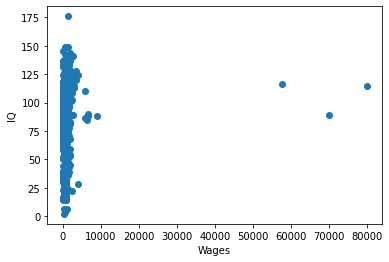

In [15]:
plt.scatter(data.wage, data.IQ)
plt.ylabel('IQ')
plt.xlabel('Wages')

Text(0.5, 0, 'unemployment rate')

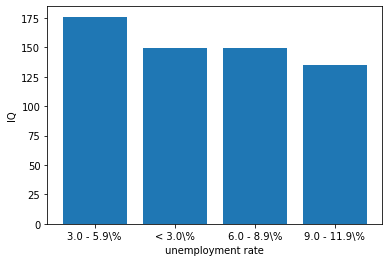

In [17]:
plt.bar(data.unemprate, data.IQ)
plt.ylabel('Average IQ')
plt.xlabel('unemployment rate')

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 996 entries, 0 to 995
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IQ         996 non-null    int64  
 1   wage       996 non-null    float64
 2   childsupp  996 non-null    int64  
 3   welfare    996 non-null    object 
 4   race       996 non-null    object 
 5   tenure     996 non-null    int64  
 6   sex        996 non-null    object 
 7   famsize    996 non-null    int64  
 8   empstat    996 non-null    object 
 9   region     996 non-null    object 
 10  marital    996 non-null    object 
 11  eduyrs     996 non-null    object 
 12  age        996 non-null    int64  
 13  urban      996 non-null    object 
 14  unemprate  996 non-null    object 
dtypes: float64(1), int64(5), object(9)
memory usage: 116.8+ KB


In [23]:
data.empstat.value_counts()

EMPLOYED              854
OUT OF LABOR FORCE    106
UNEMPLOYED             36
Name: empstat, dtype: int64

In [24]:
### Creating dummy variables using one hot encoding
x_train = data.drop('empstat',axis = 1)
y_train = data.empstat

x_train.head()

,IQ,wage,childsupp,welfare,race,tenure,sex,famsize,region,marital,eduyrs,age,urban,unemprate
0,105,1282.0,0,NO,WHITE,162,MALE,3,NORTHEAST,MARRIED,12TH GRADE,28,URBAN,3.0 - 5.9\%
1,112,1081.0,0,NO,WHITE,523,FEMALE,2,NORTHEAST,MARRIED,2ND YR COL,29,URBAN,3.0 - 5.9\%
2,137,-4.0,0,NO,WHITE,-4,FEMALE,3,NORTHEAST,MARRIED,4TH YR COL,29,RURAL,< 3.0\%
3,114,1009.0,0,NO,WHITE,375,FEMALE,3,NORTHEAST,MARRIED,12TH GRADE,30,RURAL,3.0 - 5.9\%
4,90,1237.0,0,NO,WHITE,158,FEMALE,2,NORTHEAST,MARRIED,12TH GRADE,26,URBAN,3.0 - 5.9\%


In [25]:
# geting all categorical data

# select non-numerical columns
non_numeric_cols =x_train.select_dtypes(exclude=['int', 'float'])

# get column names as a list
non_numeric_col_names = list(non_numeric_cols.columns)

print(non_numeric_col_names)

['welfare', 'race', 'sex', 'region', 'marital', 'eduyrs', 'urban', 'unemprate']


In [26]:
numeric_data = x_train.drop(non_numeric_col_names, axis = 1)

In [32]:
numeric_data

,IQ,wage,childsupp,tenure,famsize,age
0,105,1282.0,0,162,3,28
1,112,1081.0,0,523,2,29
2,137,-4.0,0,-4,3,29
3,114,1009.0,0,375,3,30
4,90,1237.0,0,158,2,26
...,...,...,...,...,...,...
991,33,921.0,0,169,4,28
992,116,750.0,1872,88,7,29
993,105,800.0,0,9,3,27
994,112,1081.0,0,32,2,26


In [37]:
df_encoded = pd.get_dummies(x_train, columns = ['marital'])
df_encoded

,IQ,wage,childsupp,welfare,race,tenure,sex,famsize,region,eduyrs,age,urban,unemprate,marital_DIVORCED,marital_MARRIED,marital_NEVER MARRIED,marital_SEPARATED
0,105,1282.0,0,NO,WHITE,162,MALE,3,NORTHEAST,12TH GRADE,28,URBAN,3.0 - 5.9\%,0,1,0,0
1,112,1081.0,0,NO,WHITE,523,FEMALE,2,NORTHEAST,2ND YR COL,29,URBAN,3.0 - 5.9\%,0,1,0,0
2,137,-4.0,0,NO,WHITE,-4,FEMALE,3,NORTHEAST,4TH YR COL,29,RURAL,< 3.0\%,0,1,0,0
3,114,1009.0,0,NO,WHITE,375,FEMALE,3,NORTHEAST,12TH GRADE,30,RURAL,3.0 - 5.9\%,0,1,0,0
4,90,1237.0,0,NO,WHITE,158,FEMALE,2,NORTHEAST,12TH GRADE,26,URBAN,3.0 - 5.9\%,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,33,921.0,0,NO,WHITE,169,FEMALE,4,NORTHEAST,12TH GRADE,28,URBAN,3.0 - 5.9\%,0,1,0,0
992,116,750.0,1872,NO,WHITE,88,FEMALE,7,NORTH CENTRAL,10TH GRADE,29,RURAL,6.0 - 8.9\%,0,1,0,0
993,105,800.0,0,NO,WHITE,9,FEMALE,3,NORTH CENTRAL,2ND YR COL,27,RURAL,6.0 - 8.9\%,0,1,0,0
994,112,1081.0,0,NO,WHITE,32,MALE,2,NORTH CENTRAL,1ST YR COL,26,URBAN,6.0 - 8.9\%,0,1,0,0


In [40]:
df_encoded = x_train
for col in non_numeric_col_names:

  df_encoded = pd.get_dummies(df_encoded, columns=[col])


In [41]:
df_encoded 

,IQ,wage,childsupp,tenure,famsize,age,welfare_NO,welfare_YES,race_BLACK,race_OTHER,...,eduyrs_7TH YR COL,eduyrs_8TH GRADE,eduyrs_8TH YR COL OR MORE,eduyrs_9TH GRADE,urban_RURAL,urban_URBAN,unemprate_3.0 - 5.9\%,unemprate_6.0 - 8.9\%,unemprate_9.0 - 11.9\%,unemprate_< 3.0\%
0,105,1282.0,0,162,3,28,1,0,0,0,...,0,0,0,0,0,1,1,0,0,0
1,112,1081.0,0,523,2,29,1,0,0,0,...,0,0,0,0,0,1,1,0,0,0
2,137,-4.0,0,-4,3,29,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,114,1009.0,0,375,3,30,1,0,0,0,...,0,0,0,0,1,0,1,0,0,0
4,90,1237.0,0,158,2,26,1,0,0,0,...,0,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,33,921.0,0,169,4,28,1,0,0,0,...,0,0,0,0,0,1,1,0,0,0
992,116,750.0,1872,88,7,29,1,0,0,0,...,0,0,0,0,1,0,0,1,0,0
993,105,800.0,0,9,3,27,1,0,0,0,...,0,0,0,0,1,0,0,1,0,0
994,112,1081.0,0,32,2,26,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0


In [43]:
y_train_encoded  = pd.get_dummies(y_train,columns = ['empstat'])

y_train_encoded.head()

,EMPLOYED,OUT OF LABOR FORCE,UNEMPLOYED
0,1,0,0
1,1,0,0
2,0,1,0
3,1,0,0
4,1,0,0


In [48]:
y_train_encoded['EMPLOYED']


0      1
1      1
2      0
3      1
4      1
      ..
991    1
992    1
993    1
994    1
995    1
Name: EMPLOYED, Length: 996, dtype: uint8

In [49]:


def log_likelihood_grad(theta, X, y):
    """
    Calculates the gradient of the log-likelihood function.

    Returns:
    numpy array of size (n_features,): gradient vector at theta
    """
    p = 1 / (1 + np.exp(-np.dot(X, theta)))
    grad = np.dot(X.T, (p - y))
    return grad

def log_likelihood_hess(theta, X):
    """
    Calculates the Hessian matrix of the log-likelihood function.

    Returns:
    numpy array of size (n_features, n_features): Hessian matrix at theta
    """
    p = 1 / (1 + np.exp(-np.dot(X, theta)))
    H = np.dot(X.T * p * (1 - p), X)
    return H


### Question h
using gradient ascent to maximize the log-likelihood 

In [50]:
def gradient_ascent(X, y, alpha=0.1, n_iterations=1000):
    """
    Performs gradient ascent to find the parameter vector that maximizes
    the log-likelihood function.

    Returns:
    numpy array of size (n_features,): parameter vector that maximizes the log-likelihood
    """
    n_samples, n_features = X.shape
    theta = np.zeros(n_features)

    for i in range(n_iterations):
        grad = log_likelihood_grad(theta, X, y)
        theta += alpha * grad

    return theta

### Question I


In [51]:

def newtons_method(X, y, n_iterations=10):
    """
    Performs Newton's method to find the parameter vector that maximizes
    the log-likelihood function.

    Returns:
    numpy array of size (n_features,): parameter vector that maximizes the log-likelihood
    """
    n_samples, n_features = X.shape
    theta = np.zeros(n_features)

    for i in range(n_iterations):
        grad = log_likelihood_grad(theta, X, y)
        hess = log_likelihood_hess(theta, X, y)
        theta -= np.linalg.inv(hess) @ grad

    return theta


In [ ]:
### L-bfgs
def log_likelihood(theta, X, y):
    p = 1 / (1 + np.exp(-X @ theta))
    return -(y * np.log(p) + (1 - y) * np.log(1 - p)).sum()


log_likelihood = log_likelihood(theta,X,y)
def optimize_lbfgsb(theta_init, X, y):
    res = minimize(log_likelihood, theta_init, args=(X, y), method='L-BFGS-B', jac=gradient)
    return res.x

In [ ]:
####Nelder mead

def optimize_nelder_mead(theta_init, X, y):
    res = minimize(log_likelihood, theta_init, args=(X, y), method='Nelder-Mead')
    return res.x


In [52]:
### Question J

In [ ]:
import matplotlib.pyplot as plt

def plot_objective_function(, true_params, method_results):
    fig, ax = plt.subplots()
    ax.set_xlabel("Number of iterations/evaluations")
    ax.set_ylabel("Objective function value")
    ax.set_title("Comparison of optimization methods")
    
    for method, result in method_results.items():
        obj_vals = [dataset.log_likelihood(true_params, theta) for theta in result["thetas"]]
        ax.plot(result["iterations"], obj_vals, label=method)
    
    ax.legend()
    plt.show()

In [ ]:
from scipy.optimize import minimize


# Perform optimization using different methods
init_theta = np.zeros(3)

# Newton's method
newton_result =newtons_method(df_encoded,y_train_encoded, init_theta)
newton_iterations = range(len(newton_result["thetas"]))
method_results = {"Newton's method": {"thetas": newton_result["thetas"], "iterations": newton_iterations}}

# L-BFGS-B


# Nelder-Mead

# Plot objective function values over time
